In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import defaultdict
import torchvision.transforms as transforms
from PIL import Image

from config import *
from dataset import CustomImageFolder
from model import CNNModel
from utils import *

In [16]:
set_seed(42)
device = get_device()
model = CNNModel()
model = load_model(model)

conv_weights = [] 
conv_layers = [] 
for module in model.children():
    if isinstance(module, nn.Conv2d):
        conv_weights.append(module.weight)
        conv_layers.append(module)

Model loaded


/Users/smolling/CNN_RiceVarieties/src/utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{args.checkpoint}/CNNmodel.pt"))


In [25]:
test_dataset = CustomImageFolder(root=args.test_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
label_dict = {0:"breed9", 1:"breed28", 2:"breed41", 3:"other"}
label_set = set()
samples_per_label = defaultdict(list)

samples_per_class = 3 
# Sample 3 images per breed
for i, (image, label, breed) in enumerate(test_loader):
    label = label.item()
    if len(samples_per_label[label]) < samples_per_class:
        samples_per_label[label].append((image, label, breed[0])) 

    # Stop when each label has enough samples
    if len(samples_per_label) == len(label_dict) and all(len(images) >= samples_per_class for images in samples_per_label.values()):
        break

# Sort samples
sample_breed = sorted(
    [sample for samples in samples_per_label.values() for sample in samples],
    key=lambda x: x[1]
)

In [29]:
all_labels = [item[1] for item in sample_breed]
all_labels

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]

In [41]:
model.eval()
test_accuracy = 0.0
for i, (images, labels, _) in enumerate(sample_breed):
    labels = torch.tensor(labels)
    images, labels = images.to(device), labels.to(device)
    outputs=model(images)
    _, predictions = torch.max(outputs.data, 1)
    test_accuracy += int(torch.sum(predictions==labels.data))
test_accuracy = test_accuracy/len(sample_breed)
test_accuracy

3 0
3 0
3 0
3 1
3 1
3 1
3 2
3 2
3 2
3 3
3 3
3 3


0.25

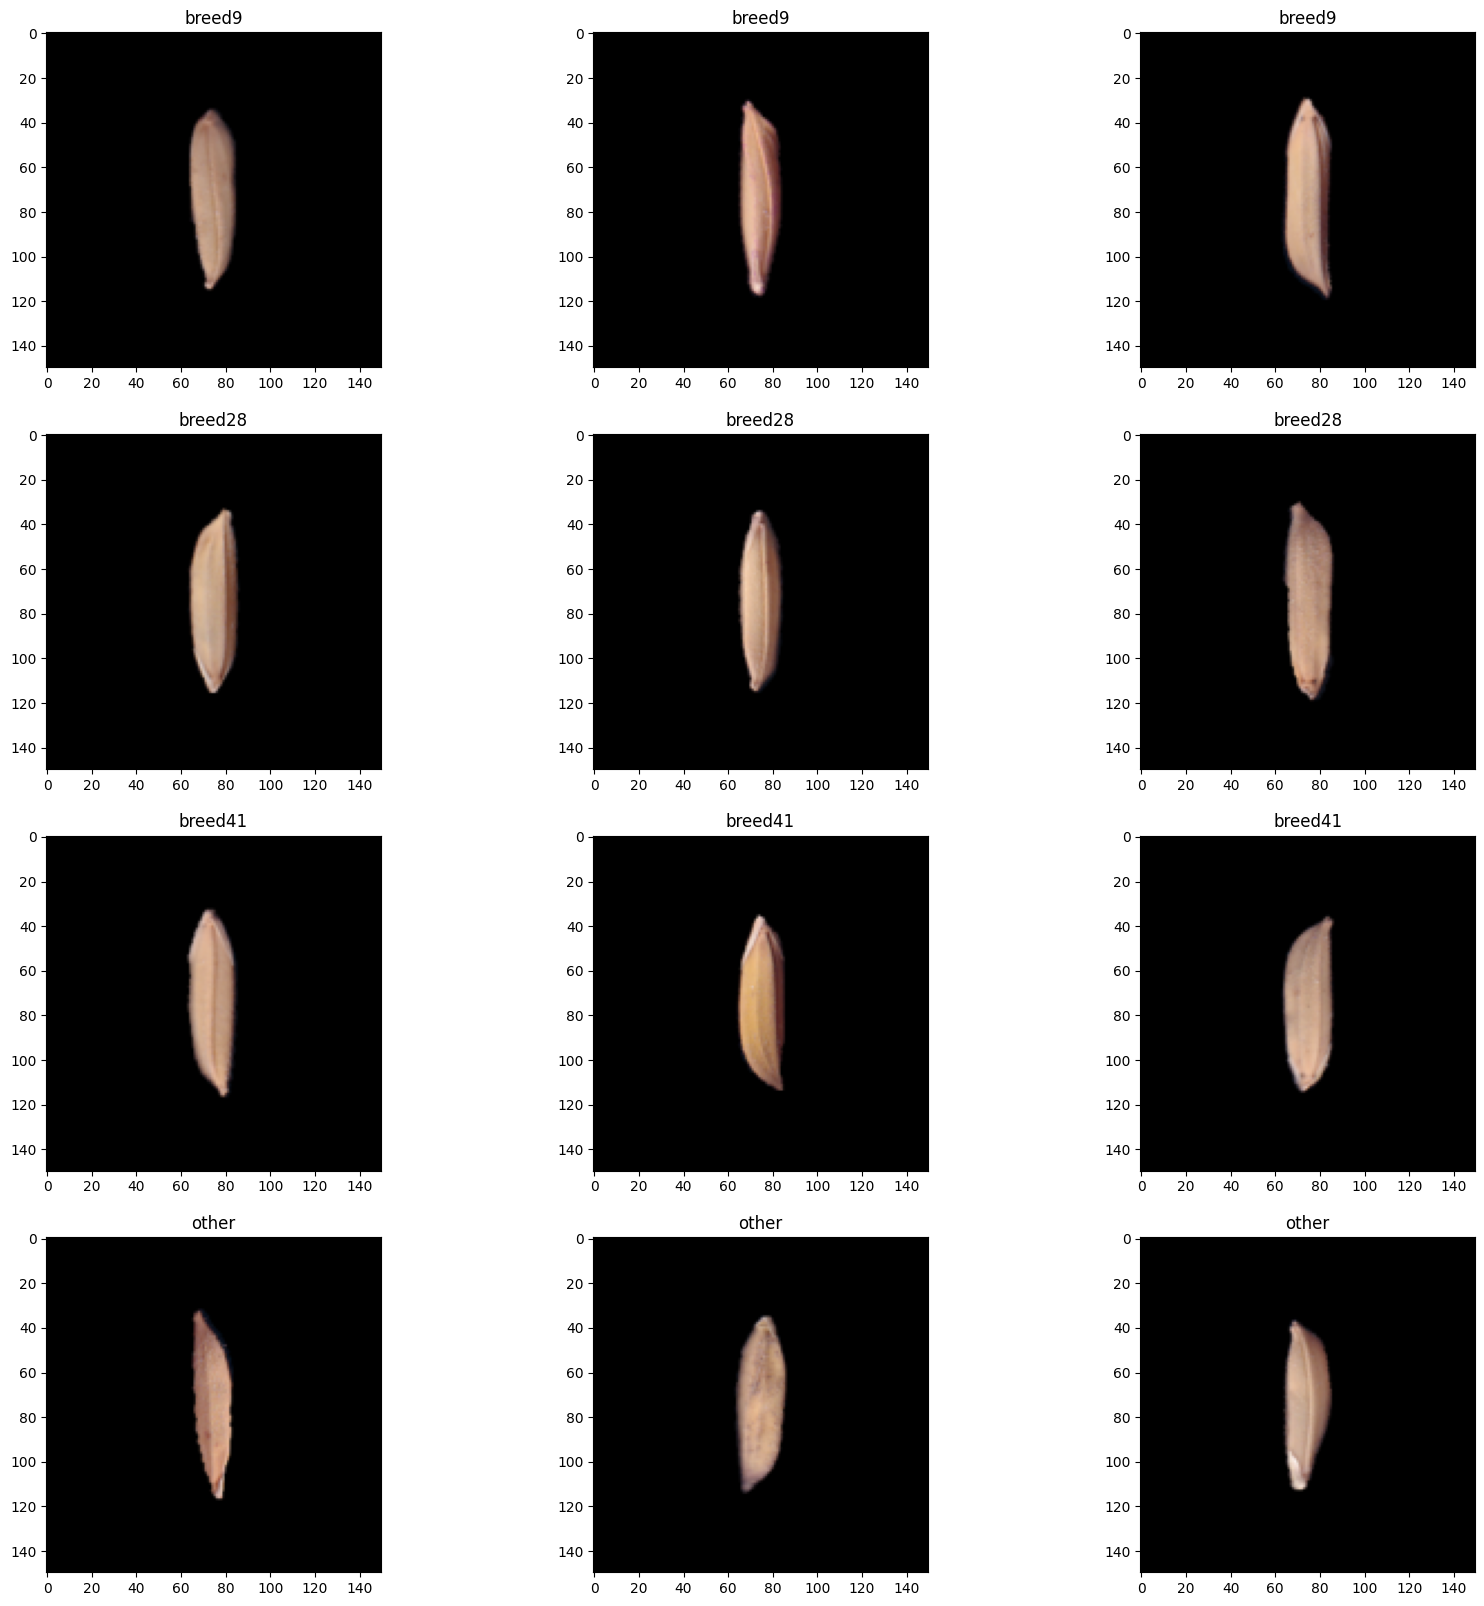

In [9]:
plt.figure(figsize=(20, 20))
for i, (image, label, breed) in enumerate(sample_breed):
    image = (image * 0.5 + 0.5).clip(0, 1).squeeze(0).permute(1,2,0).cpu().numpy()
    plt.subplot(4, 3, i+1)
    plt.imshow(image)
    plt.title(f"{label_dict[label]}")